# Basic Walkthrough - Lambert W x Gaussian Regression

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/StatMixedML/XGBoostLSS/blob/master/docs/examples/Gaussian_Regression.ipynb)

In this example, we model and predict all parameters of a univariate Lambert W x Normal distribution. Recall that distributional regression models and predicts all parameters $\theta_{ik}, k=1, \ldots, K$ parameters of a distribution $\mathcal{D}$ as a function of covariates:

\begin{equation}
y_{i} \stackrel{ind}{\sim} \mathcal{D}
  \begin{pmatrix}
     h_{1}\bigl(\theta_{i1}(x_{i})\bigr) = \eta_{i1} \\
    h_{2}\bigl(\theta_{i2}(x_{i})\bigr) = \eta_{i2}  \\ 
	\vdots \\                        
	h_{K}\bigl(\theta_{iK}(x_{i})\bigr) = \eta_{iK} 
\end{pmatrix}
\quad  ,i=1, \ldots, N. 
\end{equation}

where $h_{k}(\cdot)$ transforms each distributional parameter to the corresponding parameter scale.  For the univariate Lambert W x Normal case, we can specify the above as 


\begin{equation}
y_{i} \stackrel{ind}{\sim} \text{Lambert W} \times \mathcal{N}\bigl(\mu_{i}(x_{i}), \sigma_{i}(x_{i}), \delta_{i}(x_i)\bigr)
\end{equation}


As for the Normal distribution $\mu_{i}(\cdot) \in \mathbb{R}$ and $\sigma_i(\cdot) > 0$; the tail parameter $\delta_i(\cdot)$ in principle could be in $\mathbb{R}$ for most practical use cases it's useful to consider heavier tails than the input distribution, in which case we want $\delta \geq 0$.  Hence we apply $h_{k}(\cdot)$ activation functions that guarantee non-negative values for both $\sigma_i(\cdot)$ and for $\delta_i(\cdot)$. Typical choices are the exponential or the softplus function.

# Imports

First, we import the necessary functions.

In [1]:
import xgboostlss
from xgboostlss.model import *
from xgboostlss.distributions.LambertWGaussian import *

import multiprocessing
import seaborn as sns
import matplotlib.pyplot as plt
import plotnine
from plotnine import *
plotnine.options.figure_size = (12, 8)

n_cpu = multiprocessing.cpu_count()

In [2]:
xgboostlss.__version__

'0.4.1'

# Data

The data is simulated as a Gaussian, where $x_{true}$ is the only true feature and all others are noise variables:
- $\mu(x_{true}) = 10$
- $\sigma(x_{true}) = 1 + 1 * \bigr((0.5 < x_{true}) \& (x_{true} < 0.8)\bigl)$
- $\delta(x_{true}) = 0.05 + 0.2 * \bigr((0.2 < x_{true}) \& (x_{true} < 0.6)\bigl)$


We first generate a simulated dataset, filter for the target and covariates and then create the `xgb.DMatrix`. XGBoostLSS is designed to closely resemble the usage of XGBoost, ensuring ease of adoption and full compatibility. 

In [4]:
from xgboostlss.distributions.LambertWWeibull import *
from xgboostlss.distributions.LambertWGamma import *

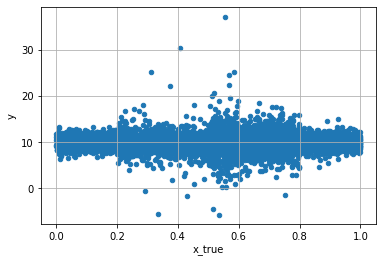

In [5]:
from xgboostlss.datasets import data_loader as xd
train, test = xd.load_simulated_tail_lambertw_gaussian_data()
train.plot.scatter(x="x_true", y="y")
plt.grid()

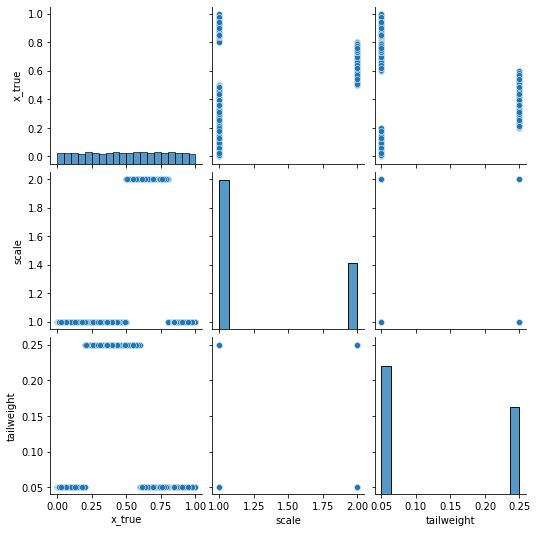

In [6]:
sns.pairplot(data=train[["x_true", "scale", "tailweight"]])

In [7]:
X_train, y_train = train.filter(regex="x"), train["y"].values
X_test, y_test = test.filter(regex="x"), test["y"].values

dtrain = xgb.DMatrix(X_train, label=y_train, nthread=n_cpu)
dtest = xgb.DMatrix(X_test, nthread=n_cpu)

# Distribution Selection

Next, we specify a Gaussian distribution. By modifying the speciﬁcation in the following, the user can specify alternative distributional assumptions. This includes the option to choose from a wide range of parametric univariate and multivariate distributions, as well as to model the data using Normalizing Flows. The user also has different function arguments for each distribution:

- `stabilization`: specifies the stabilization method for the Gradient and Hessian. Options are `None`, `MAD` and `L2`.
- `response_fn`: specifies $h_{k}(\cdot)$ and transforms the distributional parameter to the correct support. Here, we specify an exponential for $\sigma_{i}(\cdot)$ only.
- `loss_fn`: specifies the loss function used for training.  Options are `nll` (negative log-likelihood) or `crps` (continuous ranked probability score).

For additional details, see `?Gaussian`.

In [89]:
xgblss = XGBoostLSS(
    TailLambertWGaussian(stabilization="L2",  
             response_fn="exp",      
             loss_fn="nll"       
            )
)

# Hyper-Parameter Optimization

Any XGBoost hyperparameter can be tuned, where the structure of the parameter dictionary needs to be as follows:

    - Float/Int sample_type
        - {"param_name": ["sample_type", low, high, log]}
            - sample_type: str, Type of sampling, e.g., "float" or "int"
            - low: int, Lower endpoint of the range of suggested values
            - high: int, Upper endpoint of the range of suggested values
            - log: bool, Flag to sample the value from the log domain or not
        - Example: {"eta": "float", low=1e-5, high=1, log=True]}

    - Categorical sample_type
        - {"param_name": ["sample_type", ["choice1", "choice2", "choice3", "..."]]}
            - sample_type: str, Type of sampling, either "categorical"
            - choice1, choice2, choice3, ...: str, Possible choices for the parameter
        - Example: {"booster": ["categorical", ["gbtree", "dart"]]}

    - For parameters without tunable choice (this is needed if tree_method = "gpu_hist" and gpu_id needs to be specified)
        - {"param_name": ["none", [value]]},
            - param_name: str, Name of the parameter
            - value: int, Value of the parameter
        - Example: {"gpu_id": ["none", [0]]}

Depending on which parameters are optimized, it might happen that some of them are not used, e.g., when `{"booster":  ["categorical", ["gbtree", "gblinear"]]}` and `{"max_depth": ["int", 1, 10, False]}` are specified, `max_depth` is not used when `"gblinear"` is sampled, since it has no such argument.

In [90]:
# Oracle parameter loss (plugging in true values)
nfold = 4
xgblss.dist.get_params_df_loss(test[["loc", "scale", "tailweight"]], test["y"].to_frame()) / nfold

tensor(1339.9116, dtype=torch.float64)

In [91]:
xgblss.dist.get_params_df_loss(train[["loc", "scale", "tailweight"]], train["y"].to_frame()) / nfold

tensor(3158.9207, dtype=torch.float64)

In [94]:
param_dict = {
    "eta":              ["float", {"low": 1e-8,   "high": 5,     "log": True}],
    "max_depth":        ["int",   {"low": 1,      "high": 3,    "log": False}],
    "gamma":            ["float", {"low": 1e-8,   "high": 5,    "log": True}],
    "subsample":        ["float", {"low": 0.9,    "high": 1.0,   "log": False}],
    "colsample_bytree": ["float", {"low": 0.9,    "high": 1.0,   "log": False}],
    "min_child_weight": ["float", {"low": 1e-8,   "high": 0.1,   "log": True}],
    "booster":          ["categorical", ["gbtree"]]
}

np.random.seed(123)
opt_param = xgblss.hyper_opt(param_dict,
                             dtrain,
                             num_boost_round=50,        # Number of boosting iterations.
                             nfold=nfold,                    # Number of cv-folds.
                             early_stopping_rounds=5,   # Number of early-stopping rounds
                             max_minutes=20,             # Time budget in minutes, i.e., stop study after the given number of minutes.
                             n_trials=30,               # The number of trials. If this argument is set to None, there is no limitation on the number of trials.
                             silence=False,               # Controls the verbosity of the trail, i.e., user can silence the outputs of the trail.
                             seed=1,                   # Seed used to generate cv-folds.
                             hp_seed=123                 # Seed for random number generator used in the Bayesian hyperparameter search.
                            )

[I 2023-12-24 00:20:57,470] A new study created in memory with name: XGBoostLSS Hyper-Parameter Optimization


Using 5 out of 30 trials for (random) startup


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-12-24 00:22:16,723] Trial 0 finished with value: 3242.80480975 and parameters: {'eta': 0.011443649680305664, 'max_depth': 1, 'gamma': 9.405328959901798e-07, 'subsample': 0.9551314769082891, 'colsample_bytree': 0.9719468969785563, 'min_child_weight': 9.156831464317383e-06, 'booster': 'gbtree'}. Best is trial 0 with value: 3242.80480975.


/home/georg/.local/lib/python3.8/site-packages/numpy/core/_methods.py:232: RuntimeWarning: invalid value encountered in subtract


[I 2023-12-24 00:22:25,719] Trial 1 finished with value: 7485.508056499999 and parameters: {'eta': 3.401248341931563, 'max_depth': 3, 'gamma': 0.00015262025861843164, 'subsample': 0.9392117518194151, 'colsample_bytree': 0.9343178016150869, 'min_child_weight': 0.0012686679007539873, 'booster': 'gbtree'}. Best is trial 0 with value: 3242.80480975.
[I 2023-12-24 00:23:53,023] Trial 2 finished with value: 3276.0558469999996 and parameters: {'eta': 6.533212753809608e-05, 'max_depth': 1, 'gamma': 2.9011824224723694e-05, 'subsample': 0.9737995405732036, 'colsample_bytree': 0.91824917304535, 'min_child_weight': 1.6910727565077192e-07, 'booster': 'gbtree'}. Best is trial 0 with value: 3242.80480975.
[I 2023-12-24 00:25:26,980] Trial 3 finished with value: 3271.711853 and parameters: {'eta': 0.0004206776670739295, 'max_depth': 2, 'gamma': 0.003300919316844771, 'subsample': 0.984943179407779, 'colsample_bytree': 0.9724455324860635, 'min_child_weight': 0.00018930608531332073, 'booster': 'gbtree'}.

<ipython-input-95-5f79ca4f436b>:2: ExperimentalWarning: plot_timeline is experimental (supported from v3.2.0). The interface can change in the future.
<ipython-input-95-5f79ca4f436b>:3: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.


<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

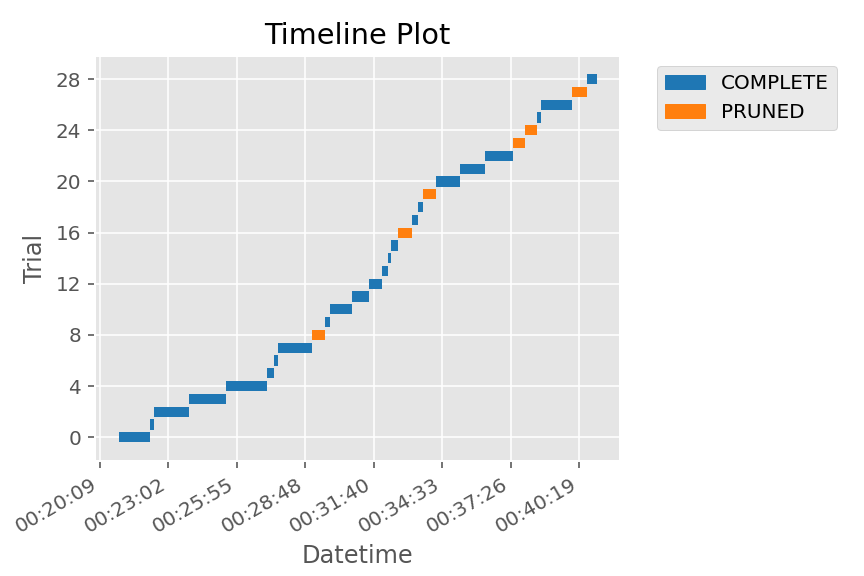

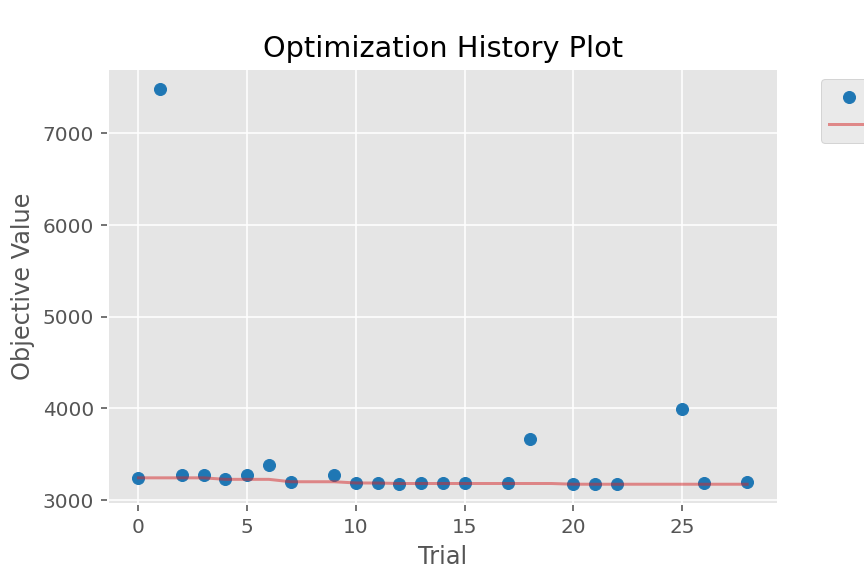

In [95]:
import optuna
optuna.visualization.matplotlib.plot_timeline(xgblss.optuna_study)
optuna.visualization.matplotlib.plot_optimization_history(xgblss.optuna_study)

<ipython-input-96-759523714b70>:2: ExperimentalWarning: plot_parallel_coordinate is experimental (supported from v2.2.0). The interface can change in the future.


<Axes: title={'center': 'Parallel Coordinate Plot'}>

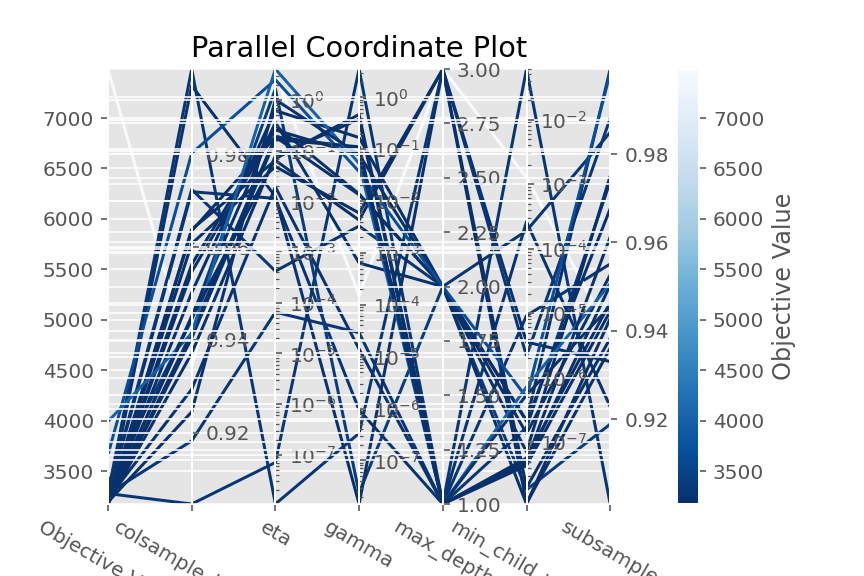

In [96]:
param_plot = [k for k, v in param_dict.items() if len(v[1]) > 1]
optuna.visualization.matplotlib.plot_parallel_coordinate(xgblss.optuna_study, params=param_plot)

# Model Training

We use the optimized hyper-parameters and train the model.

In [97]:
np.random.seed(123)

opt_params = opt_param.copy()
n_rounds = opt_params["opt_rounds"]
del opt_params["opt_rounds"]

# Train Model with optimized hyperparameters
xgblss.train(opt_params,
             dtrain,
             num_boost_round=n_rounds
             )

# Prediction

Similar to a XGBoost model, we now predict from the trained model. Different options are available:

- `samples`: draws `n_samples` from the predicted distribution.
- `quantiles`: calculates quantiles from the predicted distribution.
- `parameters`: returns predicted distributional parameters.

In [98]:
# Set seed for reproducibility
torch.manual_seed(123)

# Number of samples to draw from predicted distribution
n_samples = 1000
quant_sel = [0.05, 0.95] # Quantiles to calculate from predicted distribution

# Sample from predicted distribution
pred_samples = xgblss.predict(dtest,
                              pred_type="samples",
                              n_samples=n_samples,
                              seed=123)

# Calculate quantiles from predicted distribution
pred_quantiles = xgblss.predict(dtest,
                                pred_type="quantiles",
                                n_samples=n_samples,
                                quantiles=quant_sel)

# Return predicted distributional parameters
pred_params = xgblss.predict(dtest,
                             pred_type="parameters")

In [99]:
pred_samples.head()

,y_sample0,y_sample1,y_sample2,y_sample3,y_sample4,y_sample5,y_sample6,y_sample7,y_sample8,y_sample9,...,y_sample990,y_sample991,y_sample992,y_sample993,y_sample994,y_sample995,y_sample996,y_sample997,y_sample998,y_sample999
0,10.671154,9.201435,10.890352,10.813819,-6.913229,10.156131,12.982667,8.556123,11.827641,8.968566,...,10.648414,10.784625,9.158769,9.758117,10.380650,9.549431,11.103432,8.562824,10.047483,7.534687
1,9.725471,9.773252,9.961627,10.814697,12.465498,10.226000,9.678374,9.882236,9.097995,13.098125,...,10.086212,8.873569,6.803946,9.483570,12.414818,9.509992,9.369565,12.352281,9.640889,9.265469
2,9.715210,10.119487,10.491904,8.472618,10.856714,8.298891,10.308479,11.421084,10.818345,9.844136,...,11.467136,10.612968,8.811490,9.808595,8.649169,9.326774,10.029493,10.170127,10.722045,9.531619
3,9.418252,11.017366,9.822543,6.512855,10.416093,9.606373,9.355072,9.186111,8.676766,10.595734,...,12.188725,11.062758,9.677224,10.396880,9.561403,10.640899,9.941638,9.575966,10.480448,9.551099
4,10.359633,10.066171,9.675404,9.555143,10.158352,9.433079,8.873400,8.902352,10.529284,7.732285,...,9.862326,10.805603,9.729514,11.184772,10.666521,9.215442,10.181309,9.723946,9.241806,10.514802


In [100]:
pred_quantiles.head()

,quant_0.05,quant_0.95
0,6.735927,13.726101
1,8.118966,11.803451
2,8.338765,11.892830
3,8.462177,11.471901
4,7.647350,12.166688


In [101]:
pred_params.head()

,loc,scale,tailweight
0,10.063120,1.787995,0.139778
1,9.903641,1.001213,0.062691
2,10.012737,0.977232,0.066561
3,9.956059,0.906488,0.051647
4,9.992576,1.038599,0.225537


In [104]:
xgblss.dist.get_params_df_loss(test[["loc", "scale", "tailweight"]], test["y"].to_frame())

tensor(5359.6466, dtype=torch.float64)

In [105]:
xgblss.dist.get_params_df_loss(pred_params[["loc", "scale", "tailweight"]], test["y"].to_frame())

tensor(5372.5366, dtype=torch.float64)

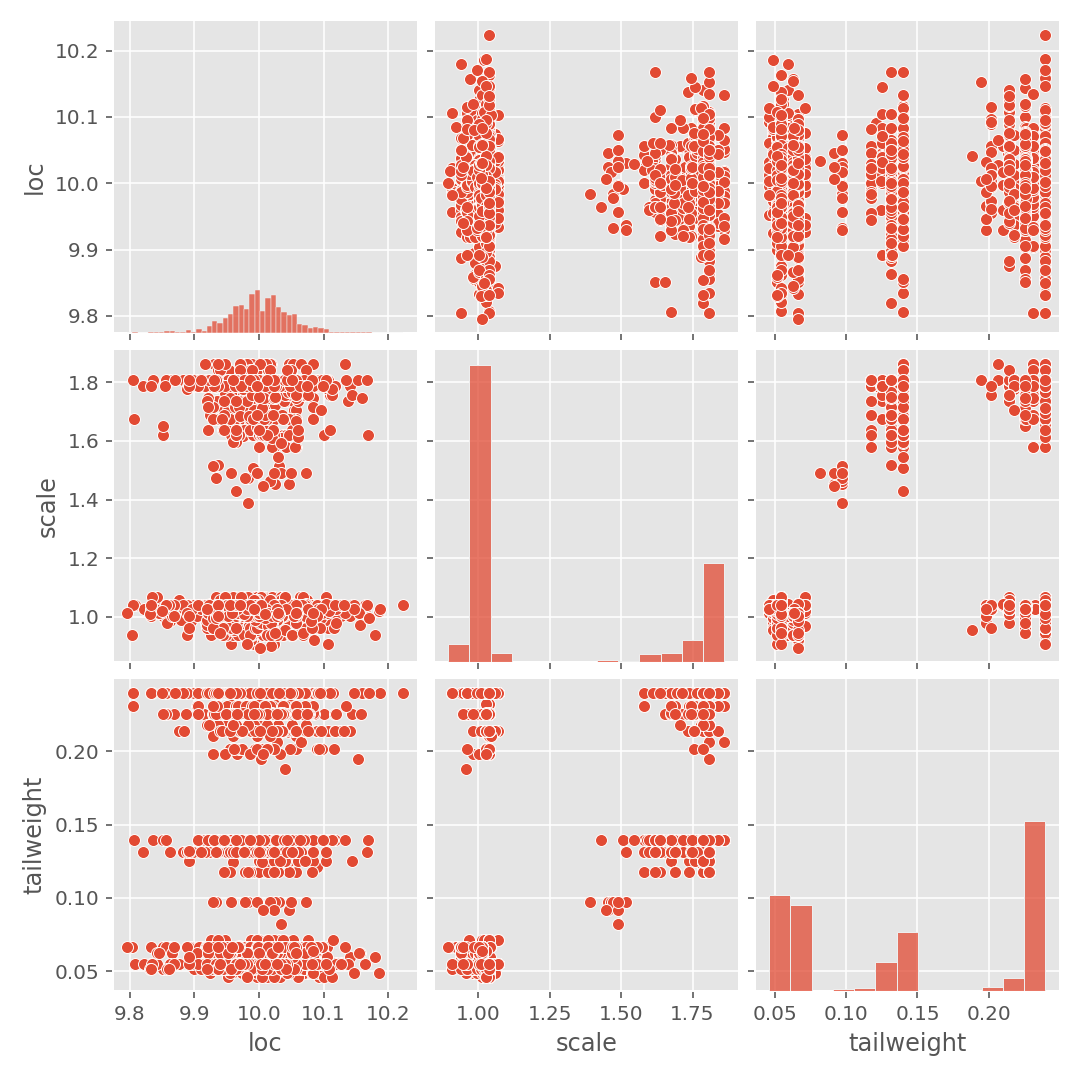

In [106]:
import seaborn as sns
sns.pairplot(pred_params)

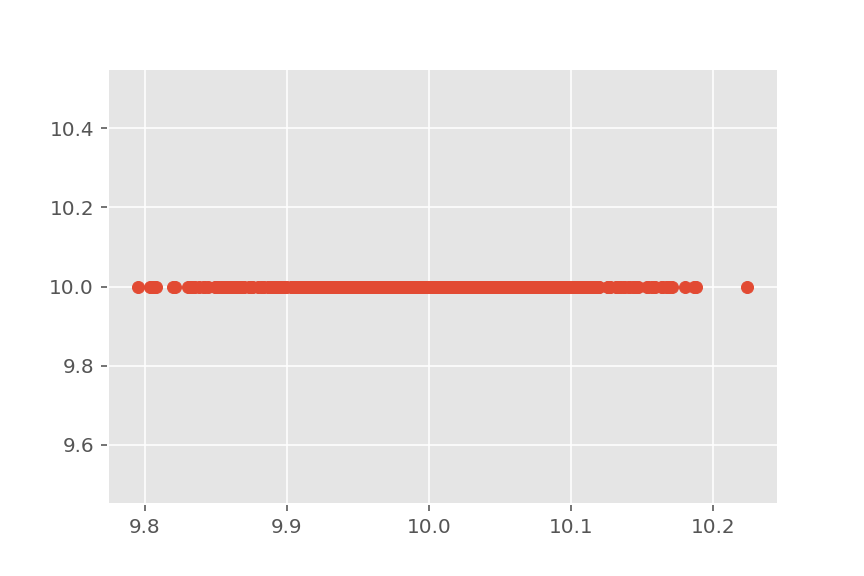

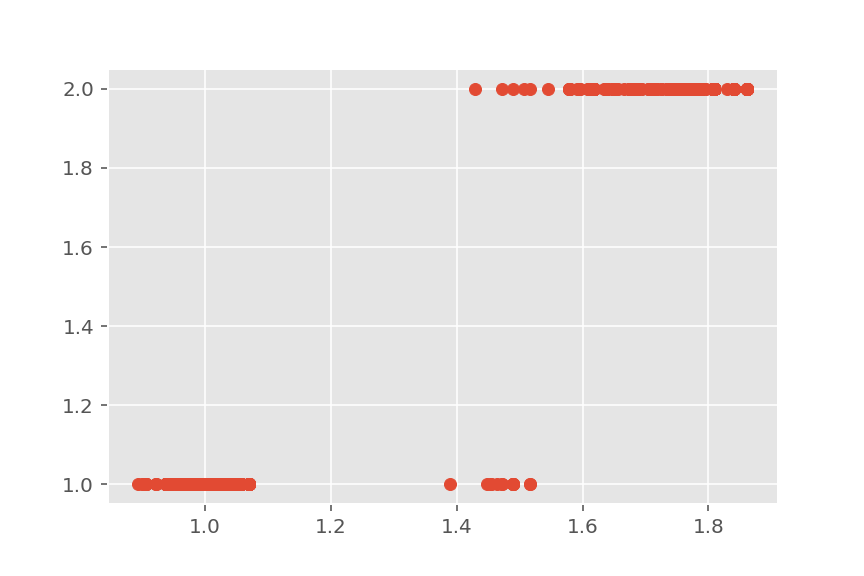

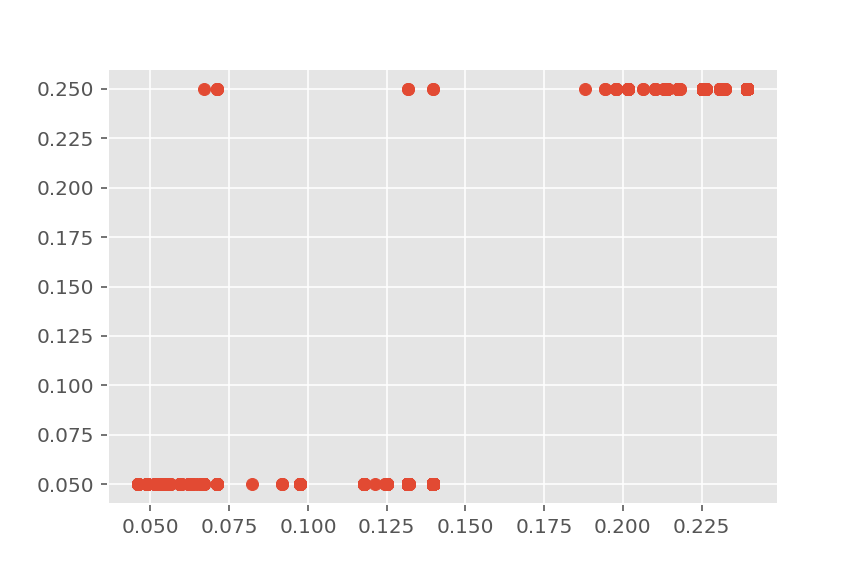

In [107]:
import matplotlib.pyplot as plt
for c in pred_params.columns:
    plt.scatter(pred_params[c], test[c])
    plt.show()

# SHAP Interpretability

To get a deeper understanding of the data generating process, XGBoostLSS also provides attribute importance and partial dependence plots using the Shapley-Value approach.

/home/georg/.local/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [00:43:07] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
/home/georg/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
/home/georg/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:2830: RuntimeWarning: invalid value encountered in true_divide


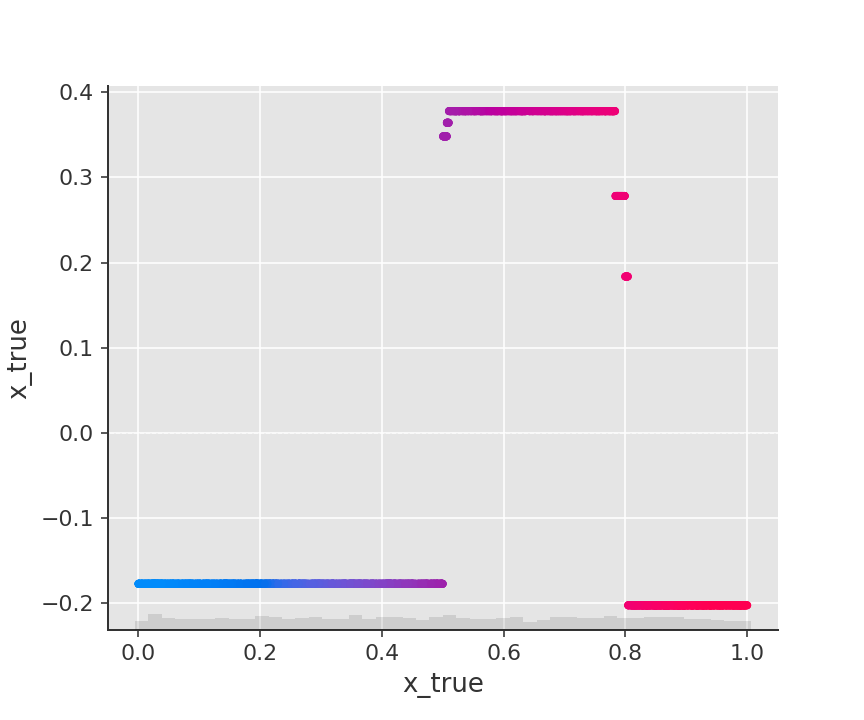

In [108]:
# Partial Dependence Plot of how x_true acts on variance
xgblss.plot(X_test,
            parameter="scale",
            feature="x_true",
            plot_type="Partial_Dependence")

/home/georg/.local/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [00:43:08] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


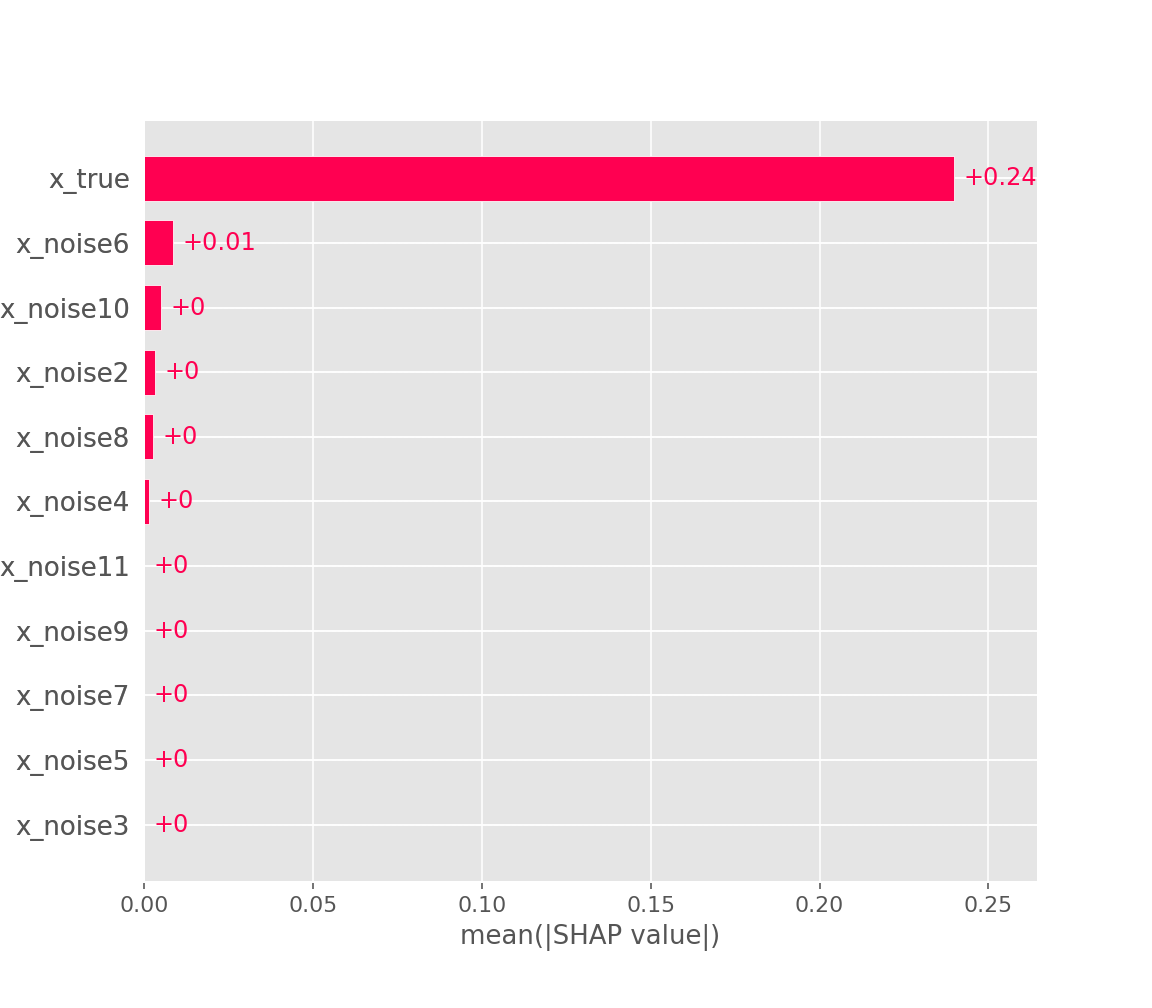

In [109]:
# Feature Importance of scale parameter
xgblss.plot(X_test,
            parameter="scale",
            plot_type="Feature_Importance")

/home/georg/.local/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [00:43:09] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
/home/georg/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
/home/georg/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:2830: RuntimeWarning: invalid value encountered in true_divide


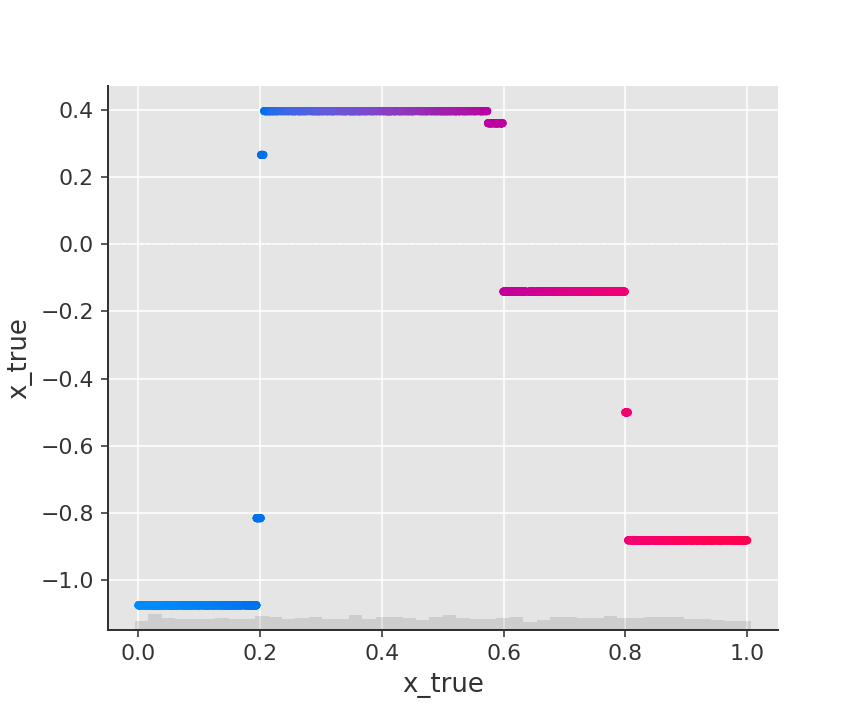

In [110]:
# Partial Dependence Plot of how x_true acts on tail parameter
xgblss.plot(X_test,
            parameter="tailweight",
            feature="x_true",
            plot_type="Partial_Dependence")

/home/georg/.local/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [00:43:09] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


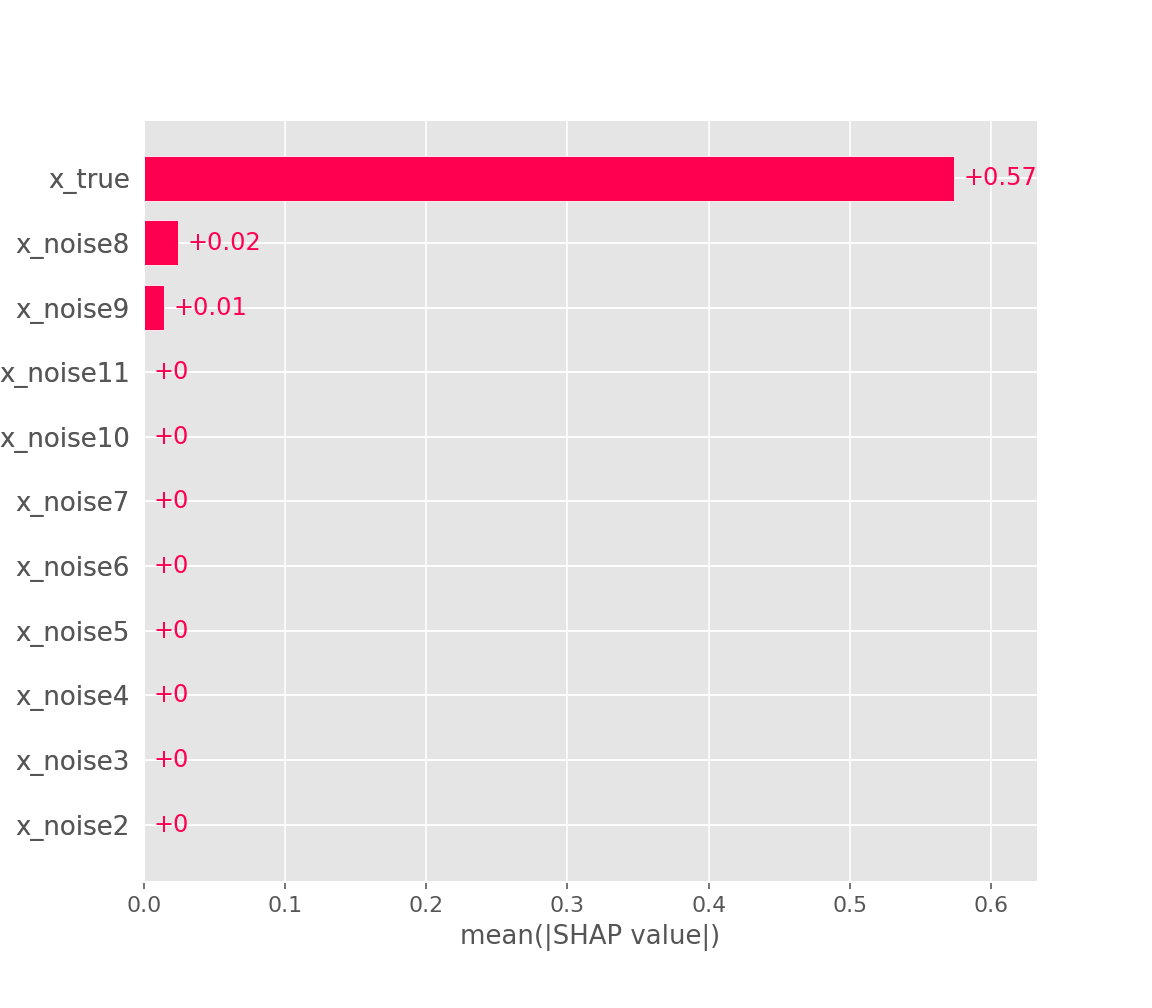

In [111]:
# Feature Importance of tail parameter
xgblss.plot(X_test,
            parameter="tailweight",
            plot_type="Feature_Importance")

# Plot of Actual vs. Predicted Quantiles

In the following, we plot the predicted quantiles (blue) and compare them to the actual quantiles (dashed-black).

/home/georg/.local/lib/python3.8/site-packages/plotnine-0.12.4-py3.8.egg/plotnine/geoms/geom_path.py:98: PlotnineWarning: geom_path: Removed 2 rows containing missing values.
/home/georg/.local/lib/python3.8/site-packages/plotnine-0.12.4-py3.8.egg/plotnine/geoms/geom_path.py:98: PlotnineWarning: geom_path: Removed 2 rows containing missing values.


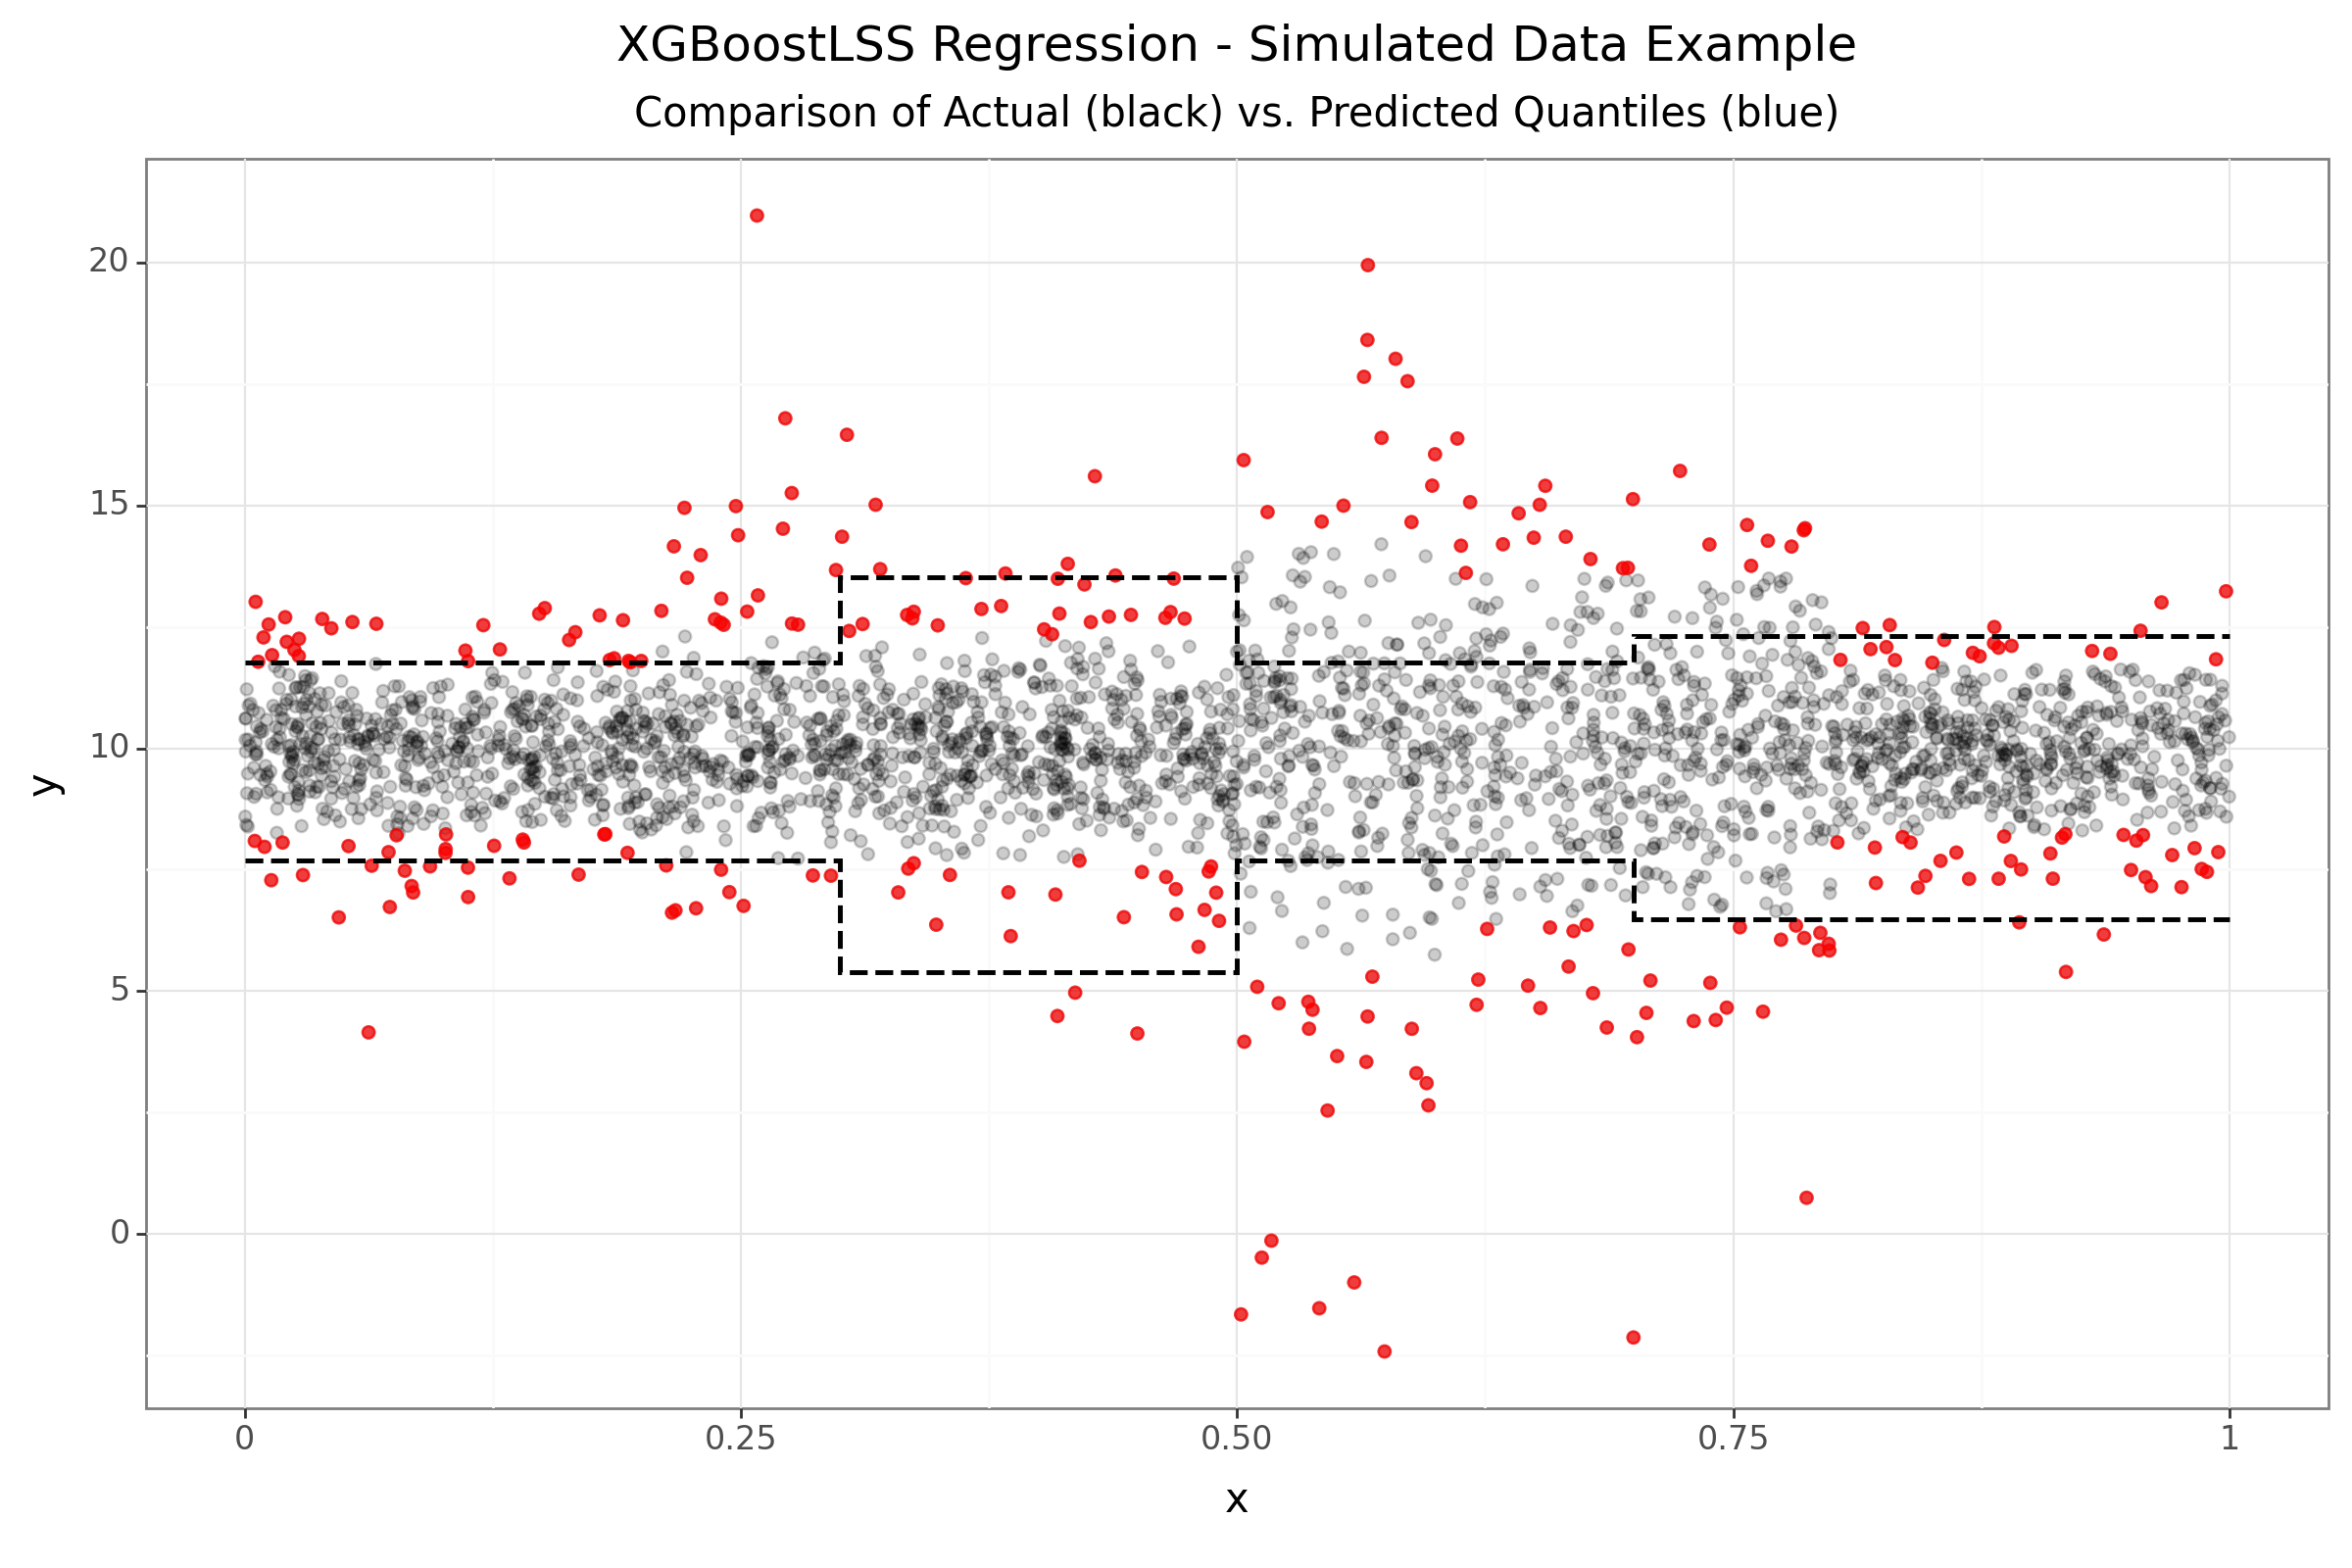

<Figure Size: (1200 x 800)>

In [112]:
np.random.seed(123)

###
# Actual Quantiles
###
q1 = test["q5"]
q2 = test["q95"]
test["quant"] = np.where(test["y"].values < q1, 0, np.where(test["y"].values < q2, 1, 2))
test["alpha"] = np.where(test["y"].values <= q1, 1, np.where(test["y"].values >= q2, 1, 0))
df_quantiles = test[test["alpha"] == 1]

# Lower Bound
yl = list(set(q1))
yl.sort()
yl = [yl[2],yl[0],yl[2],yl[1],yl[1]]
sfunl = pd.DataFrame({"x_true":[0, 0.3, 0.5, 0.7, 1], "y":yl})

# Upper Bound
yu = list(set(q2))
yu.sort()
yu = [yu[0],yu[2],yu[0],yu[1],yu[1]]
sfunu = pd.DataFrame({"x_true":[0, 0.3, 0.5, 0.7, 1], "y":yu})

###
# Predicted Quantiles
###
test["lb"] = pred_quantiles.iloc[:,0]
test["ub"] = pred_quantiles.iloc[:,1]

###
# Plot
###
(ggplot(test,
        aes("x_true",
            "y")) + 
 geom_point(alpha = 0.2, color = "black", size = 2) + 
 theme_bw(base_size=15) +
 theme(legend_position="none",
       plot_title = element_text(hjust = 0.5),
       plot_subtitle = element_text(hjust = 0.5)) +
 labs(title = "XGBoostLSS Regression - Simulated Data Example",
      subtitle = "Comparison of Actual (black) vs. Predicted Quantiles (blue)",
      x="x")  + 
 geom_line(aes("x_true",
               "ub"),
           size = 1,
           color = "blue", 
           alpha = 0.7) + 
 geom_line(aes("x_true",
               "lb"),
           size = 1,
           color = "blue", 
           alpha = 0.7) + 
 geom_point(df_quantiles,
            aes("x_true",
                "y"), 
            color = "red", 
            alpha = 0.7,
            size = 2) + 
 geom_step(sfunl,
           aes("x_true",
               "y"), 
           size = 1, 
           linetype = "dashed")  + 
 geom_step(sfunu,
           aes("x_true",
               "y"), 
           size = 1, 
           linetype = "dashed") 
)

# True vs. Predicted Distributional Parameters

In the following figure, we compare the true parameters of the Gaussian with the ones predicted by XGBoostLSS. The below figure shows that the estimated parameters closely match the true ones (recall that the location parameter $\mu=10$ is simulated as being a constant).

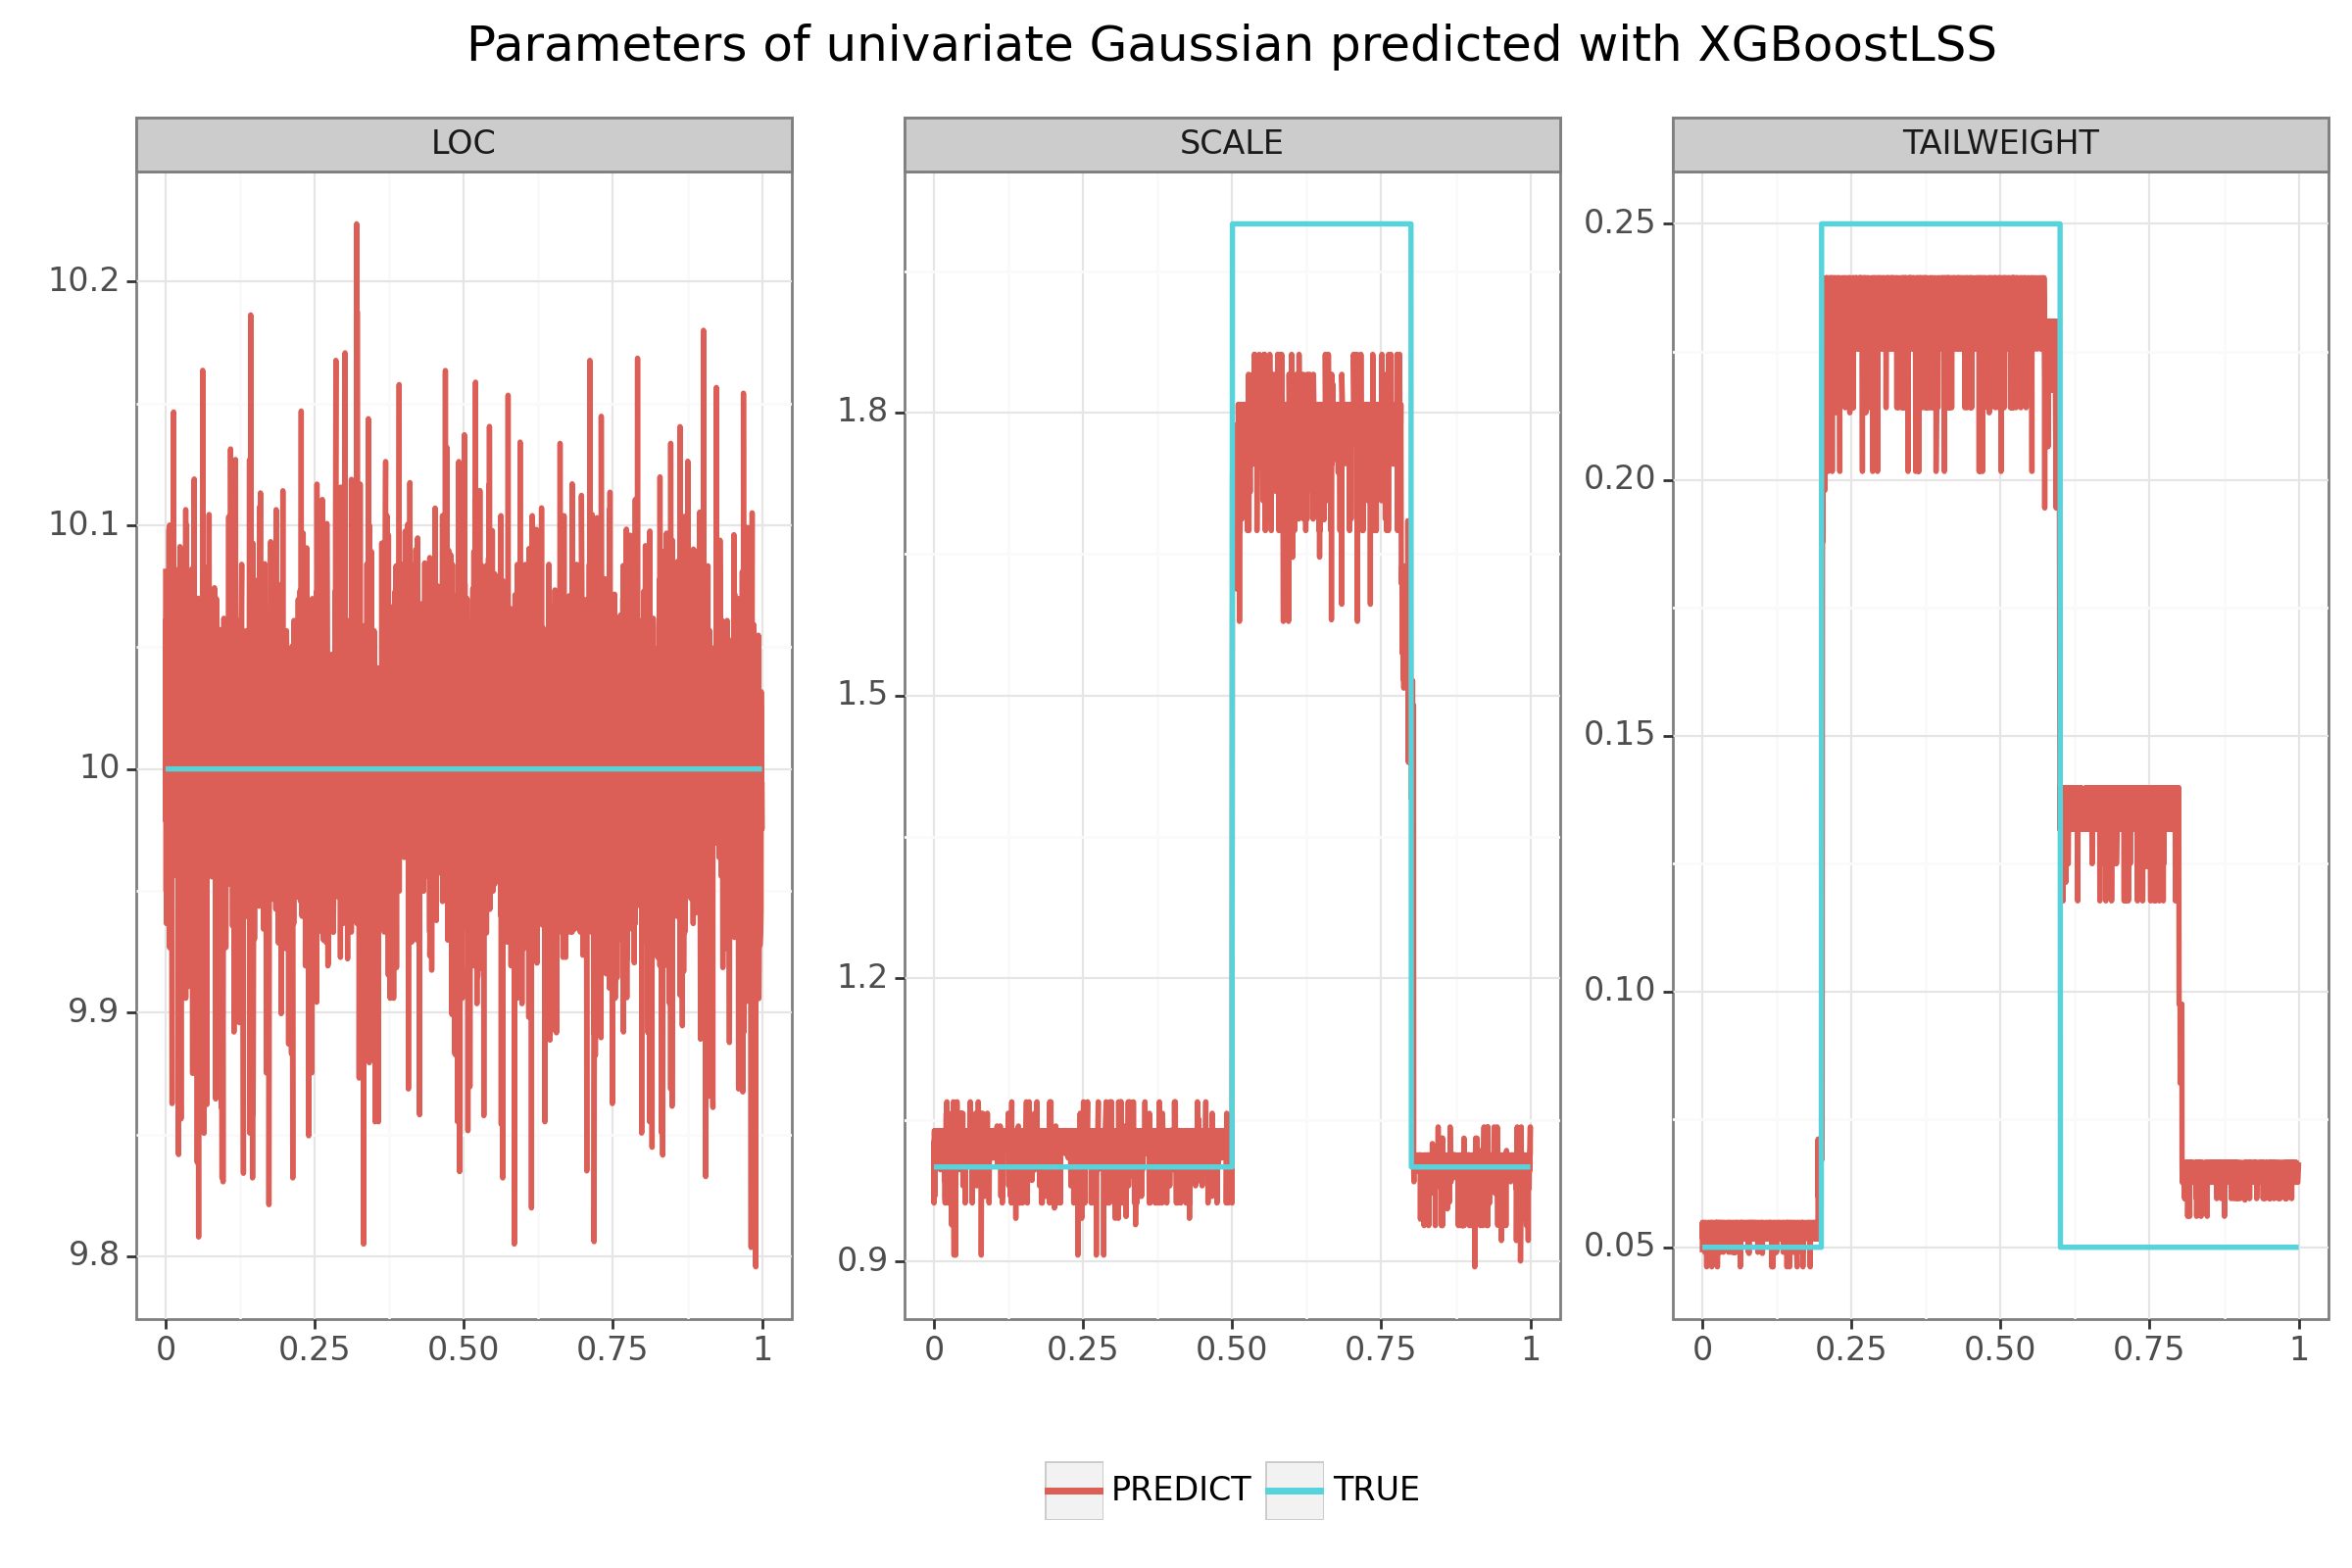

<Figure Size: (1200 x 800)>

In [113]:
pred_params["x_true"] = X_test["x_true"].values
dist_params = list(xgblss.dist.param_dict.keys())

# Data with actual values
plot_df_actual = pd.melt(test[["x_true"] + dist_params],
                         id_vars="x_true",
                         value_vars=dist_params)
plot_df_actual["type"] = "TRUE"

# Data with predicted values
plot_df_predt = pd.melt(pred_params[["x_true"] + dist_params],
                        id_vars="x_true",
                        value_vars=dist_params)
plot_df_predt["type"] = "PREDICT"

plot_df = pd.concat([plot_df_predt, plot_df_actual])

plot_df["variable"] = plot_df.variable.str.upper()
plot_df["type"] = pd.Categorical(plot_df["type"], categories = ["PREDICT", "TRUE"])

(ggplot(plot_df,
        aes(x="x_true",
            y="value",
            color="type")) +
 geom_line(size=1.1) + 
 facet_wrap("variable",
            scales="free") + 
 labs(title="Parameters of univariate Gaussian predicted with XGBoostLSS",
      x="",
      y="") + 
 theme_bw(base_size=15) + 
 theme(legend_position="bottom",
       plot_title = element_text(hjust = 0.5),
       legend_title = element_blank())
)

# Actual vs. Predicted

Since we predict the entire conditional distribution, we can overlay the point predictions with predicted densities, from which we can also derive quantiles of interest. 

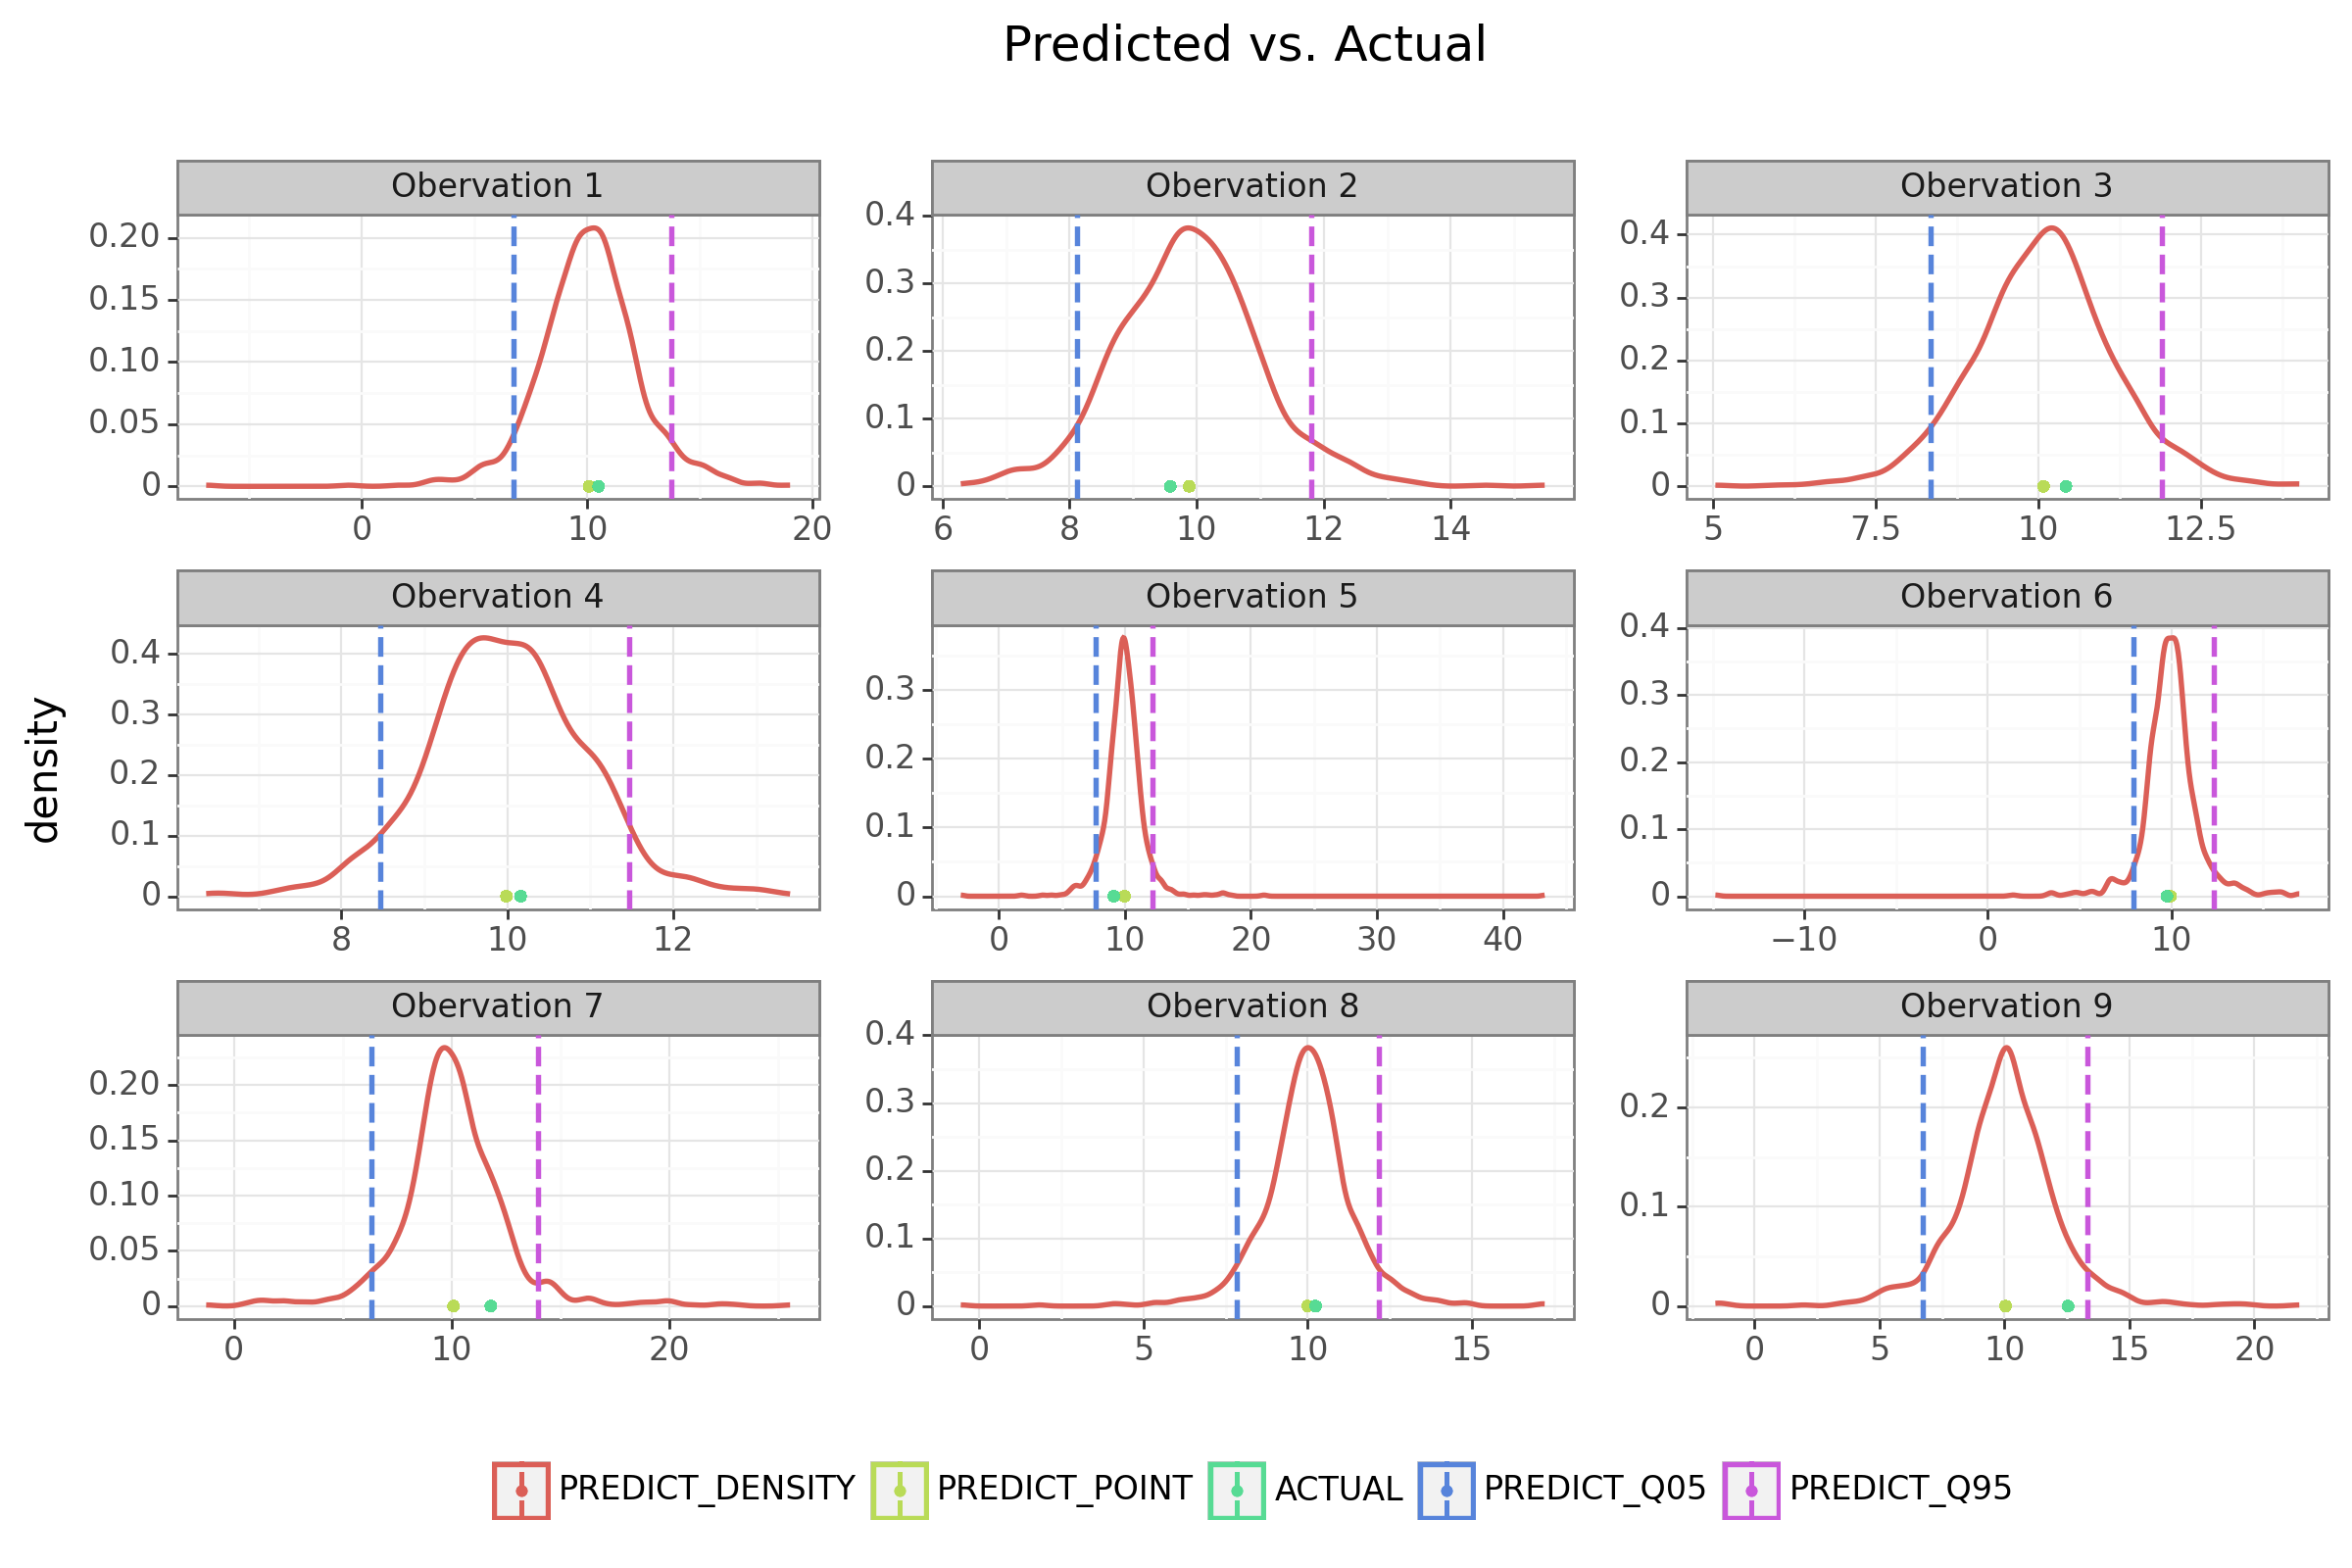

In [114]:
y_pred = []

n_examples = 9

for i in range(n_examples):    
    y_samples = pd.DataFrame(pred_samples.values[i,:].reshape(-1,1), columns=["PREDICT_DENSITY"])
    y_samples["PREDICT_POINT"] = y_samples["PREDICT_DENSITY"].mean()
    y_samples["PREDICT_Q05"] = y_samples["PREDICT_DENSITY"].quantile(q=quant_sel[0])
    y_samples["PREDICT_Q95"] = y_samples["PREDICT_DENSITY"].quantile(q=quant_sel[1])
    y_samples["ACTUAL"] = y_test[i]
    y_samples["obs"]= f"Obervation {i+1}"
    y_pred.append(y_samples)
    
pred_df = pd.melt(pd.concat(y_pred, axis=0), id_vars="obs")
pred_df["obs"] = pd.Categorical(pred_df["obs"], categories=[f"Obervation {i+1}" for i in range(n_examples)])
df_actual, df_pred_dens, df_pred_point, df_q05, df_q95 = [x for _, x in pred_df.groupby("variable")]

plot_pred = (
    ggplot(pred_df,
           aes(color="variable")) + 
    stat_density(df_pred_dens,
                 aes(x="value"),
                 size=1.1) + 
    geom_point(df_pred_point,
               aes(x="value",
                   y=0),
               size=1.4) + 
    geom_point(df_actual,
               aes(x="value",
                   y=0),
               size=1.4) + 
    geom_vline(df_q05, 
               aes(xintercept="value",
                   fill="variable",
                   color="variable"),
               linetype="dashed",
               size=1.1) + 
    geom_vline(df_q95, 
               aes(xintercept="value",
                   fill="variable",
                   color="variable"),
               linetype="dashed",
               size=1.1) + 
    facet_wrap("obs",
               scales="free",
               ncol=3) + 
    labs(title="Predicted vs. Actual \n",
         x = "") + 
    theme_bw(base_size=15) +
    scale_fill_brewer(type="qual", palette="Dark2") + 
    theme(legend_position="bottom",
          plot_title = element_text(hjust = 0.5),
          legend_title = element_blank()
         )
)

print(plot_pred)